<a href="https://colab.research.google.com/github/sevendaystoglory/temp/blob/main/Adversarial_Certification_of_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define transformation: convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: access one batch
for images, labels in train_loader:
    print(images.shape)  # torch.Size([64, 1, 28, 28])
    print(labels.shape)  # torch.Size([64])
    break


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.75MB/s]

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class neural_net(nn.Module):
  def __init__(self, input_dim = 784, hidden_dim_1 = 256, hidden_dim_2 = 32, final_dim = 10) -> None:
     super().__init__()
     self.linear_1 = nn.Linear(input_dim, hidden_dim_1)
     self.linear_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
     self.logits = nn.Linear(hidden_dim_2, final_dim)
     self.criterion = nn.CrossEntropyLoss()

  def forward(self, x):
    #x --> B, H, W
    x = x.view(x.shape[0], -1)
    x=self.linear_1(x)
    x=torch.relu(x)
    x=self.linear_2(x)
    logits = self.logits(x)
    return logits

In [4]:
device = torch.device("cuda")
model = neural_net().to(device)

In [5]:
import torch.optim as optim
import torch.nn as nn


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
num_epochs = 10

for epoch in range(num_epochs):
    for x, labels in train_loader:
        x, labels = x.to(device), labels.to(device)

        # Forward pass
        logits = model(x)  # shape: [B, 10]

        # Compute loss
        loss = criterion(logits, labels)

        # Backprop + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.1227
Epoch [2/10], Loss: 0.0116
Epoch [3/10], Loss: 0.0031
Epoch [4/10], Loss: 0.0199
Epoch [5/10], Loss: 0.0201
Epoch [6/10], Loss: 0.0079
Epoch [7/10], Loss: 0.0090
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0595
Epoch [10/10], Loss: 0.0001


In [6]:
model.eval()
correct = 0
for x, labels in test_loader: #one batch at a time
  x, labels = x.to(device), labels.to(device)
  logits = model(x) #Bx10
  loss = model.criterion(logits, labels)
  _, predicted_index = torch.max(logits, dim=1)
  for i, prediction in enumerate(predicted_index):
    if prediction == labels[i]:
      correct+=1

In [55]:
class IBPCertifier:
    def __init__(self, model):
        """
        model: your trained nn.Module returning logits of shape [B, C]
        """
        self.model = model
        self.label = None

    def certify(self, x0, epsilon, x0_orig=None, y0=None):
        logits = self.model(x0.squeeze(0))
        _, self.label = torch.max(logits, dim=1)

        l, u = self._init_interval(x0, epsilon)

        for layer in self._layers():
            l, u = self._propagate_layer(layer, l, u)

        return self._check_certification(l, u, x0_orig, y0), (l, u)


    def _init_interval(self, x0, eps):
        # clamp to [0,1] after normalization
        lower = torch.clamp(x0 - eps, min=0.0, max=1.0)
        upper = torch.clamp(x0 + eps, min=0.0, max=1.0)
        return lower, upper

    def _layers(self):
        # return the sequence: [linear_1, relu, linear_2, relu, logits_layer]
        # you can inspect self.model's modules, or list them manually
      return [
          # first, a flatten‐operation
          "flatten",
          self.model.linear_1,
          nn.ReLU(),
          self.model.linear_2,
          nn.ReLU(),
          self.model.logits
      ]

    def _propagate_layer(self, layer, l_in, u_in):
        if layer == "flatten":
            # collapse anything beyond the batch dim
            B = l_in.size(0)
            l_in = l_in.view(B, -1)
            u_in = u_in.view(B, -1)
            return l_in, u_in

        elif isinstance(layer, nn.Linear):
            # now l_in, u_in are [B, 784] and W is [256,784]
            W = layer.weight
            b = layer.bias
            W_pos = torch.clamp(W, min=0)
            W_neg = torch.clamp(W, max=0)

            # sign‑split bound prop
            l_out = F.linear(l_in, W_pos, b) + F.linear(u_in, W_neg, None)
            u_out = F.linear(u_in, W_pos, b) + F.linear(l_in, W_neg, None)
            return l_out, u_out

        elif isinstance(layer, nn.ReLU):
            # bounding box outsize ReLU, no trapezoid.
            return torch.relu(l_in), torch.relu(u_in)

        else:
            raise NotImplementedError

    def _check_certification(self, l_out, u_out, x0_orig=None, y0=None):
        """
        l_out, u_out: output lower/upper bounds from IBP [1, C]
        x0_orig: original input image [1,1,28,28] (optional)
        y0: true label (int or tensor) (optional)
        """
        t = self.label
        lower_true = l_out[0, t]

        C = u_out.size(1)
        mask = torch.ones(C, dtype=torch.bool, device=u_out.device)
        mask[t] = False
        max_other = u_out[0, mask].max()
        certified = (lower_true > max_other)

        # ——— plot logit intervals ———
        lows = l_out[0].cpu().detach().numpy()
        ups = u_out[0].cpu().detach().numpy()
        classes = list(range(C))

        plt.figure(figsize=(6,4))
        for i in classes:
            plt.plot([i, i], [lows[i], ups[i]])
        plt.scatter(classes, lows, label='lower bound')
        plt.scatter(classes, ups,  label='upper bound')
        plt.axhline(lows[t], linestyle='--', label=f'true class {t} lower')
        plt.xticks(classes)
        plt.xlabel("Class index")
        plt.ylabel("Logit value")
        plt.title("IBP output intervals per class")
        plt.legend()
        plt.grid(True)
        plt.show()

        # ——— visualize misclassified input ———
        if x0_orig is not None and y0 is not None:
            print("sishtum")
            # Get clean prediction
            with torch.no_grad():
                pred_clean = self.model(x0_orig).argmax(1).item()
            true_label = y0.item() if isinstance(y0, torch.Tensor) else y0
            if pred_clean != true_label:
                plt.figure(figsize=(3,3))
                plt.imshow(x0_orig.squeeze().cpu(), cmap='gray')
                plt.title(f"Misclassified Input\nTrue: {true_label}, Pred: {pred_clean}")
                plt.axis('off')
                plt.show()
        return certified



In [52]:
# 1. Import / define your certifier (make sure IBPCertifier is in scope)
# from your_certifier_module import IBPCertifier

# 2. Instantiate it with your trained model
certifier = IBPCertifier(model)

# 3. Grab one sample from the test set
x_batch, y_batch = next(iter(test_loader))
x0, y0 = x_batch[0:1].to(device), y_batch[0].item()  # shape [1,1,28,28], scalar label

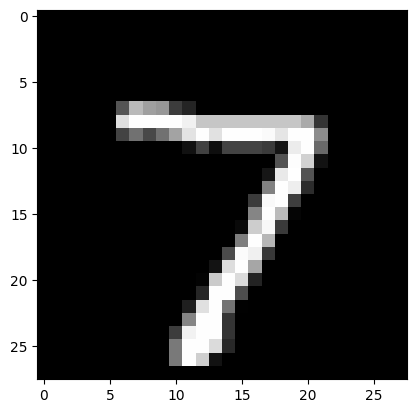

7


In [53]:
import matplotlib.pyplot as plt

plt.imshow(x0.squeeze(0).squeeze(0).to("cpu"), cmap='grey')
plt.show()
print(y0) # To check if the model even predicts the class properly before certifying.

sishtum
❌ Example 7 is NOT certified at ε = 0.1
True‐class lower bound: 2.412485361099243
Largest other upper bound: 6.998123645782471


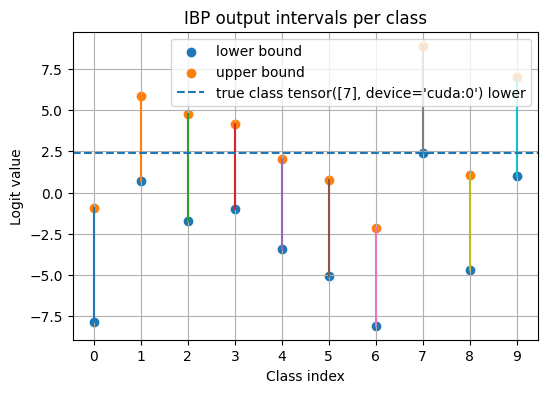

In [54]:
# 4. Choose your perturbation radius
epsilon = 0.1  # L∞ radius

# 5. Run certification
# x0 = input in [1,1,28,28]
# y0 = corresponding label
certified, (l_out, u_out) = certifier.certify(x0, epsilon=0.1, x0_orig=x0, y0=y0)


# 6. Interpret results
if certified:
    print(f"✅ Example {y0} is certified robust at ε = {epsilon}")
else:
    print(f"❌ Example {y0} is NOT certified at ε = {epsilon}")
    # Optionally see where it failed:
    print("True‐class lower bound:", l_out[0, y0].item())
    print("Largest other upper bound:", u_out[0, torch.arange(10)!=y0].max().item())

In [27]:
def get_deviant_from_ibp_box(model, l, u, y0, u_out):
    """
    Build a deviant input by choosing the corner of the input box
    that favors the strongest competing class (based on final layer).
    """
    # Step 1: Find strongest competing class
    competing_classes = torch.arange(u_out.size(1), device=u_out.device) != y0
    j = u_out[0, competing_classes].argmax().item()
    j = torch.arange(u_out.size(1), device=u_out.device)[competing_classes][j].item()

    # Step 2: Use final layer weights to guide input choice
    # Get gradient signal back to input space
    final_weight = model.logits.weight[j]  # shape: [hidden_dim]
    # Approximate as fully positive influence => just pick u for all dims
    # (or reverse if you want to be more nuanced)

    # Flatten bounds
    l_flat = l.view(1, -1)
    u_flat = u.view(1, -1)

    # Just pick u_flat to simulate worst-case
    x_star_flat = u_flat.clone()

    x_star = x_star_flat.view_as(l)
    return x_star, j


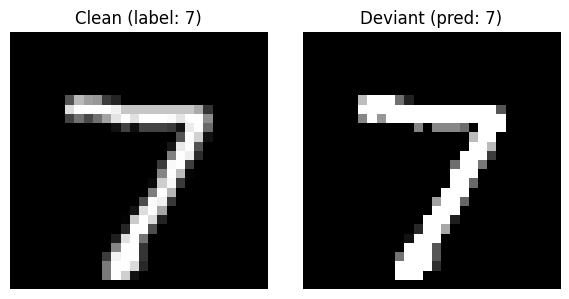

In [29]:
# 1) Recompute the input interval bounds (l0, u0)
l0 = torch.clamp(x0 - epsilon, min=0.0, max=1.0)  # shape [1,1,28,28]
u0 = torch.clamp(x0 + epsilon, min=0.0, max=1.0)  # shape [1,1,28,28]

# 2) Build the deviant from the input box
x_star, adv_class = get_deviant_from_ibp_box(model, l0, u0, y0, u_out)

# 3) Now x_star has shape [1,1,28,28] → you can pass it straight to your model
pred_star = model(x_star).argmax(1).item()

# 4) Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title(f"Clean (label: {y0})")
plt.imshow(x0.cpu().squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Deviant (pred: {pred_star})")
plt.imshow(x_star.cpu().squeeze(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()